# VJM Modelling

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Rx(q):
    T = np.array([[1, 0, 0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q), np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def dRx(q):
    T = np.array([[0, 0, 0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def Ry(q):
    T = np.array([[np.cos(q), 0, np.sin(q), 0],
                  [0, 1, 0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q), np.cos(q), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [np.cos(q), -np.sin(q), 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dTx():
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dTy():
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]])
    return T


def FK(q, thetas, links):
    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])
    return T

In [4]:
links_length = np.array([0.4, 0.5, 0.5, 0.2, 0.1, 0.1])
diameters = np.array([0.2, 0.05, 0.05, 0.01, 0.01, 0.01])
thetas = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [5]:
def IK(pos, links, phi):
    x = pos[0]
    y = pos[1]
    z = pos[2]
    flag = 1 # elbow up and down

    q0 = np.arctan2(y,x)
    
    v = z - links[0]
    w = x*np.cos(q0) + y*np.sin(q0)

    q2 =  np.arccos(((z-links[0])**2 + (x*np.cos(q0)+y*np.sin(q0))**2-links[1]**2-links[2]**2)/(2*links[1]*links[2]))

    # print(q2)

    c = -links[2]*np.sin(q2)
    q1 = np.arctan2(v,w) + flag*np.arctan2(np.sqrt(v**2+w**2-c**2),c)

    q3 = 0.01
    q4 = 0.01
    q5 = 0.01

    q = np.array([q0, q1, q2, q3, q4, q5])
    return q


In [6]:
f = FK([np.pi, 1, 0.01, 0.01, 0.01, 0.01], thetas, links_length)

ik = IK([0.7, 0, 0, 0.1, 0.1, 0.1], links_length, 0)

In [7]:
print(f)

[[-0.48884793 -0.01581973 -0.87222557 -0.99287758]
 [-0.00558851 -0.99975826  0.02126495 -0.00792954]
 [-0.87235112  0.01526977  0.48864135  0.93861885]
 [ 0.          0.          0.          1.        ]]


In [8]:
print(ik)

[0.         1.68470205 1.26610367 0.01       0.01       0.01      ]


In [9]:
# Stiffness parameters for links
E = 6.9000e+10
G = 2.5500e+10

LinkDiameter = 0.15
A = np.pi * (LinkDiameter ** 2) / 4

Iy = np.pi * (LinkDiameter ** 4) / 64
Iz = np.pi * (LinkDiameter ** 4) / 64
Ip = Iy + Iz

def JacobianForTheta(q, thetas, links):
    T = FK(q, thetas, links)
    T[0:3, 3] = 0
    T_inv = np.transpose(T)

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             dRz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    J1 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             dRy(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    J2 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             dRy(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    J3 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             dRx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    J4 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])


    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             dRy(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    J5 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])
    

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             dRy(thetas[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    J6 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    J = np.hstack([J1, J2, J3, J4, J5, J6])
    return J



## Jacobian for q

In [10]:
def JacobianForQ(q, thetas, links):
    T = FK(q, thetas, links)
    T[0:3, 3] = 0
    T_inv = np.transpose(T)

    dT = np.linalg.multi_dot([Tz(links[0]),
                             dRz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_1 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             dRy(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_2 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             dRy(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_3 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             dRx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_4 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])


    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             dRy(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             Rx(q[5]),
                             Ry(thetas[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_5 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])
    

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Rz(thetas[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Ry(thetas[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Ry(thetas[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Rx(thetas[3]),
                             Ry(q[4]),
                             Ry(thetas[4]),
                             Tz(links[5]),
                             dRx(q[5]),
                             Ry(thetas[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_6 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    J_q = np.hstack([Jq_1, Jq_2, Jq_3, Jq_4, Jq_5, Jq_6])
    return J_q



In [11]:
def KThetaLeg():
    JointStiffness = np.array([4e+6, 1e+6, 1e+6, 0.05e+6, 0.05e+6, 0.05e+6])
    JointStiffness = np.diag(JointStiffness)

    return JointStiffness

In [12]:
K_theta = KThetaLeg()
externalForce = np.array([[100], [0], [0], [0], [0], [0]])

In [13]:
def KcVJM(Ktheta, Jtheta):
    Kc_total = []
    # zeros_4 = np.zeros((6, 4))
    Kc0 = np.linalg.pinv(np.linalg.multi_dot([Jtheta, np.linalg.inv(Ktheta), np.transpose(Jtheta)]))
    # print(Kc0)
    
    Kc_total.append(Kc0)
    return Kc_total

In [14]:
def CalculateDeflections(links, forces):
    x_pos = np.array([])
    y_pos = np.array([])
    z_pos = np.array([])
    deflections = np.array([])

    xlinSpace = np.linspace(0.1, 0.6, 16)
    ylinSpace = np.linspace(0.1, 0.7, 16)
    zlinSpace = np.linspace(0.1, 0.7, 16)


    for x in xlinSpace:
        xData = np.array([])
        yData = np.array([])
        zData = np.array([])
        dData = np.array([])

        for y in ylinSpace:
            for z in zlinSpace:
                ee_pos = np.array([x, y, z])

                q_passive = IK(ee_pos, links_length, 0)

                # Jq = JacobianForQ(q_passive, thetas, links_length)

                Jtheta = JacobianForTheta(q_passive, thetas, links_length)

                Kc = KcVJM(K_theta, Jtheta)

                dt = np.linalg.pinv(Kc).dot(forces)

                deflection = np.sqrt(dt[0][0]**2+ dt[0][1]**2 + dt[0][2]**2)

                xData = np.append(xData, x)
                yData = np.append(yData, y)
                zData = np.append(zData, z)
                dData = np.append(dData, deflection)

        x_pos = np.append(x_pos, xData)
        y_pos = np.append(y_pos, yData)
        z_pos = np.append(z_pos, zData)
        deflections = np.append(deflections, dData)

    return x_pos, y_pos, z_pos, deflections

In [15]:
import sympy as sp

x = 0.6
y = 0.7
z = 0.7

ee_pos = np.array([x, y, z])
q_passive = IK(ee_pos, links_length, 0)

Jtheta = JacobianForTheta(q_passive, thetas, links_length)

Kc = np.array(KcVJM(K_theta, Jtheta)).reshape(6, 6)

sp.Matrix(Kc)

Matrix([
[ 888075824.682646, -582401051.066388,  9609833.62293324,  -386646747.04663, -398817110.201758,  1251538291.05817],
[-582401051.066349,  409695389.883644, -17891352.3347568,  259373077.531404,  268563483.952156, -841542551.838221],
[ 9609833.62291509, -17891352.3347453,  6932527.03292726,  -6762259.9423008, -7280127.20164472,  22455358.0419358],
[-386646747.046625,  259373077.531418, -6762259.94230866,  170138113.911272,  175699987.530279, -550708655.153909],
[-398817110.201751,  268563483.952169, -7280127.20165281,  175699987.530278,  181539487.101052, -568861459.031827],
[ 1251538291.05814, -841542551.838262,  22455358.0419612, -550708655.153907, -568861459.031827,  1783298828.37793]])

In [16]:
from numpy.linalg import inv
import sympy as sp

x = 0.6
y = 0.7
z = 0.7

ee_pos = np.array([x, y, z])
q_passive = IK(ee_pos, links_length, 0)

K_theta = KThetaLeg()
Jtheta = JacobianForTheta(q_passive, thetas, links_length)
Jq = JacobianForQ(q_passive, thetas, links_length)

Kc0 = inv(Jtheta@inv(K_theta)@Jtheta.T)
K_c =  Kc0-Kc0 @(Jq@(inv(Jq.T@(Kc0)@Jq)))@(Jq.T@Kc0)
sp.Matrix(K_c)

Matrix([
[-1.21593475341797e-5,  6.91413879394531e-6,  2.42143869400024e-7,   5.0663948059082e-6,  5.24520874023438e-6, -1.62124633789063e-5],
[  1.9073486328125e-5, -1.13248825073242e-5, -2.49594449996948e-7, -8.01682472229004e-6,  -8.2850456237793e-6,  2.61068344116211e-5],
[-6.16535544395447e-7,  3.35276126861572e-7,  1.67638063430786e-8,  2.50525772571564e-7,  2.59838998317719e-7, -8.08387994766235e-7],
[  6.3776969909668e-6, -3.75509262084961e-6, -2.09547579288483e-7, -2.62260437011719e-6, -2.71201133728027e-6,  8.70227813720703e-6],
[-1.31130218505859e-6,  1.37090682983398e-6, -2.84053385257721e-7,  7.45058059692383e-7,  7.74860382080078e-7, -2.26497650146484e-6],
[-5.48362731933594e-6,  1.43051147460938e-6,  8.30739736557007e-7,  1.66893005371094e-6,  1.66893005371094e-6,  -5.7220458984375e-6]])

In [17]:
xScatter, yScatter, zScatter, dScatter = CalculateDeflections(links_length, externalForce)

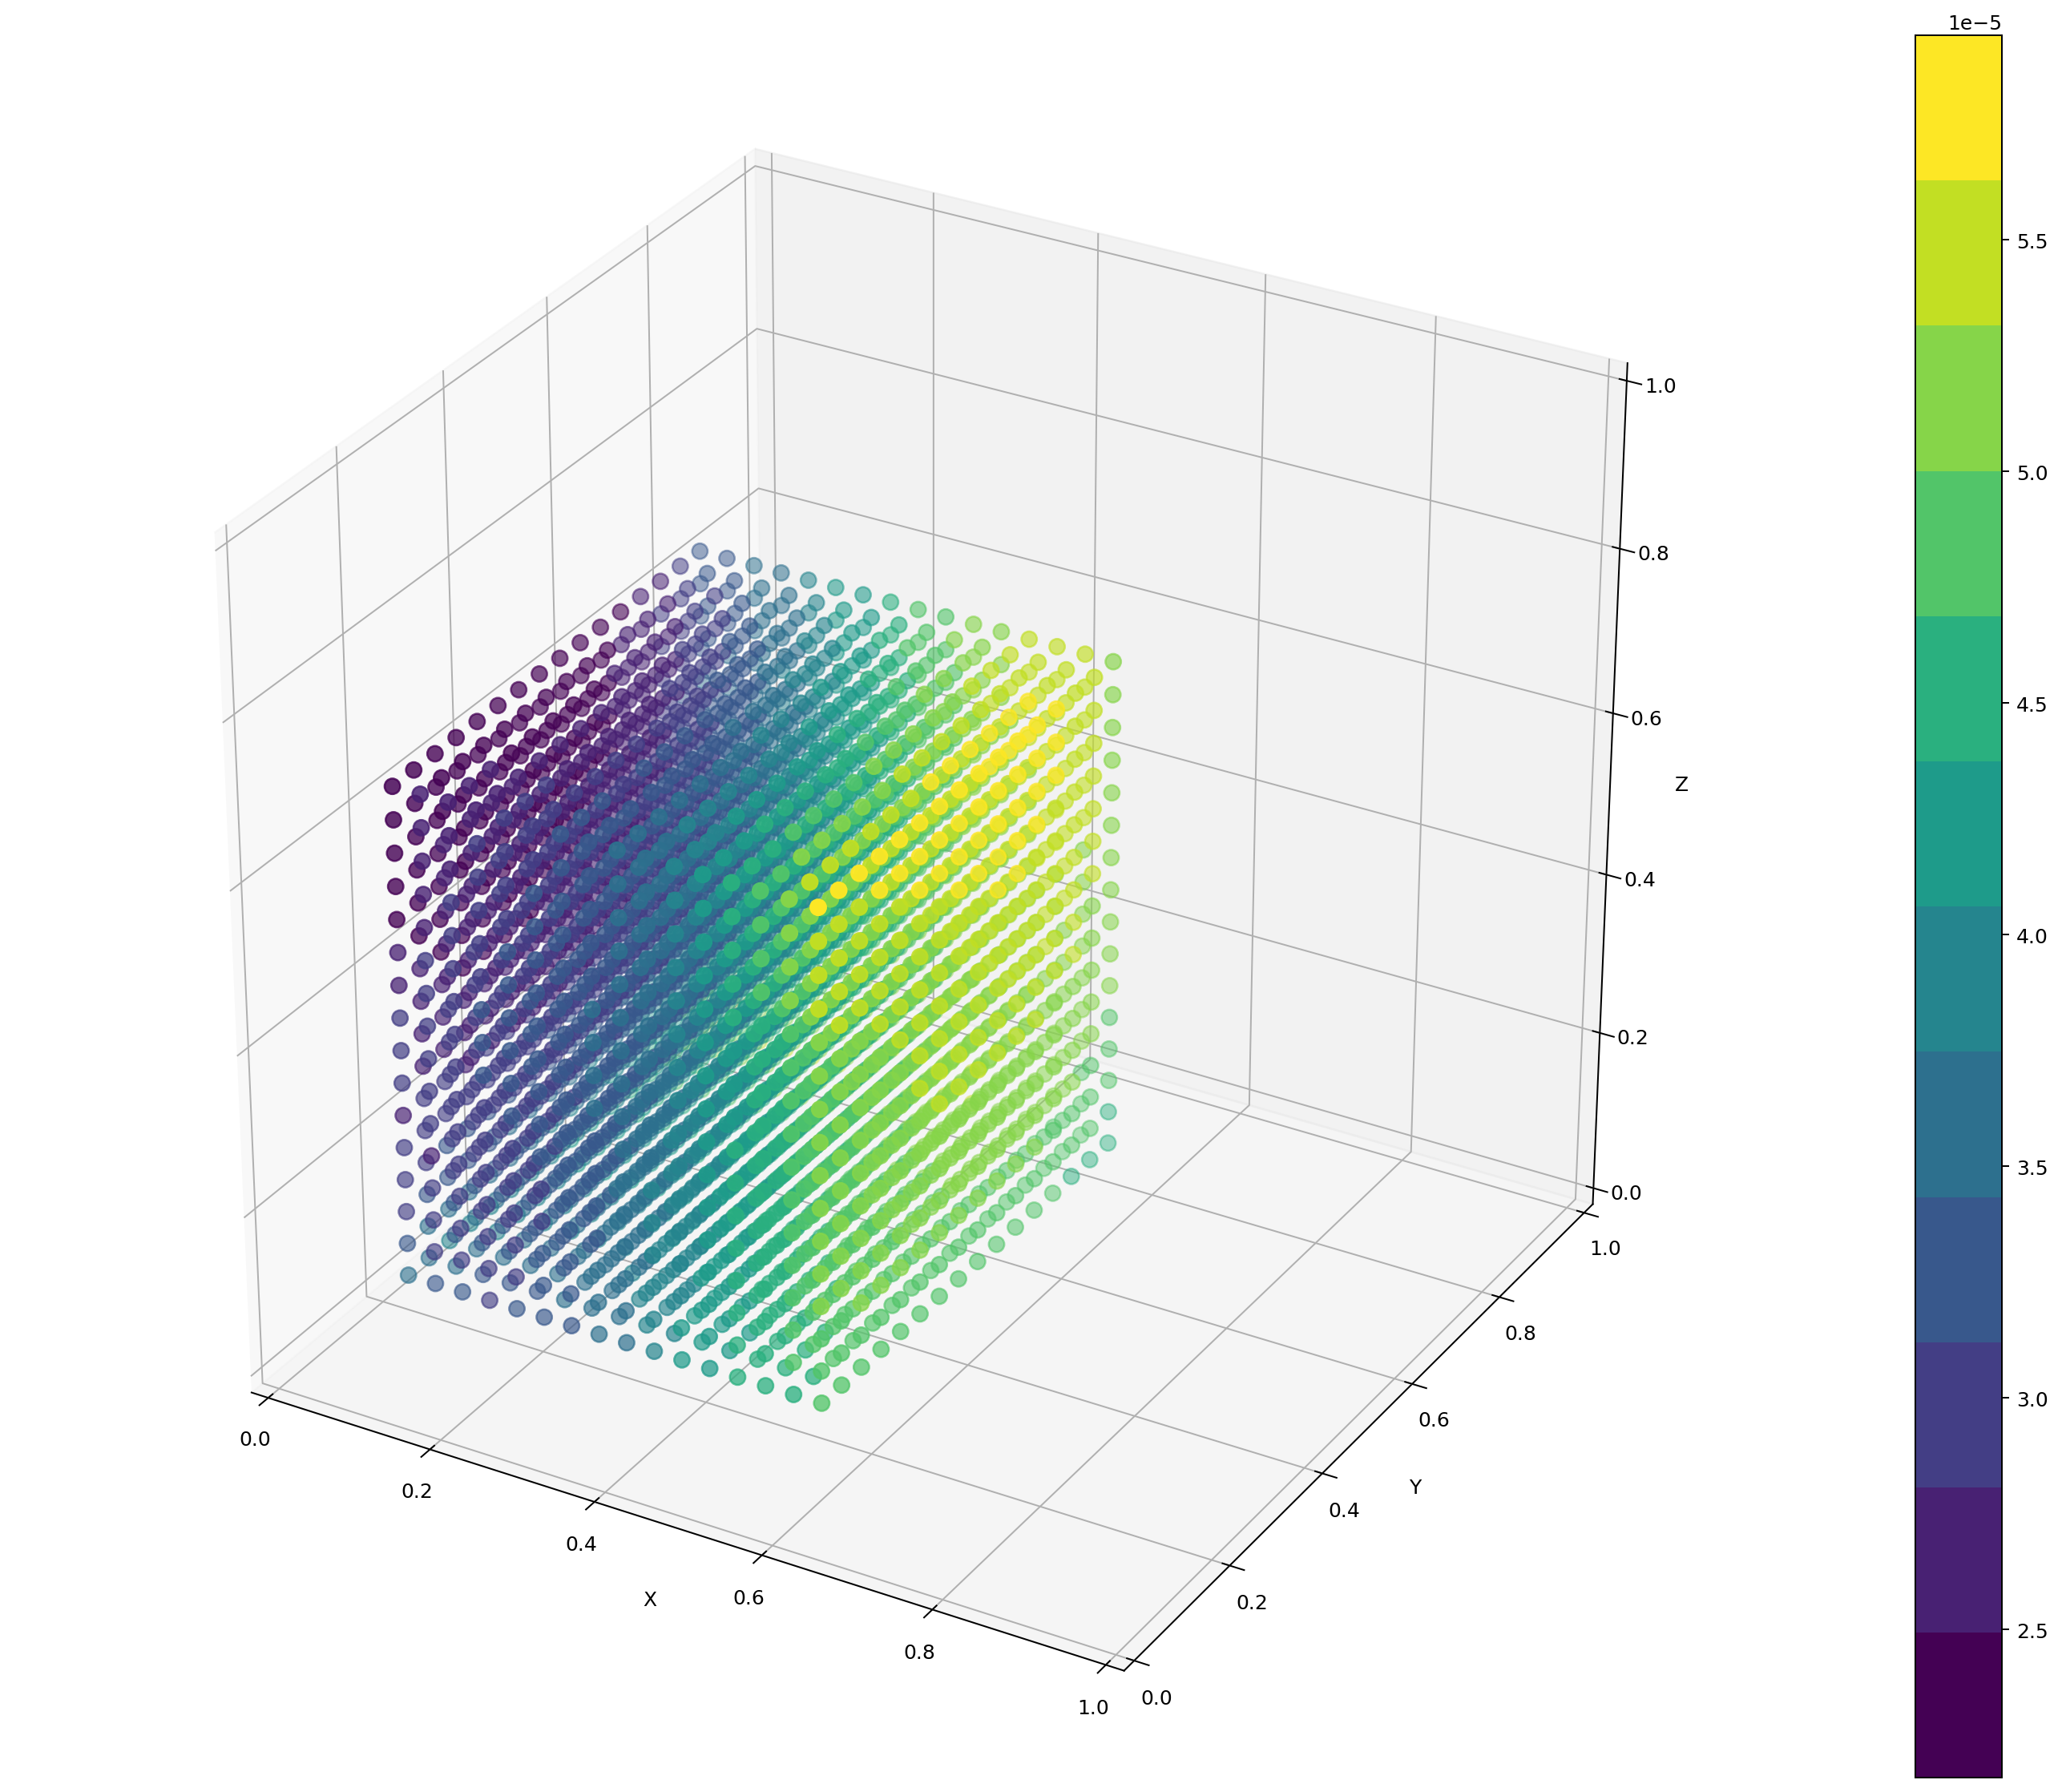

In [20]:
def plotDeflectionMap(x_pos, y_pos, z_pos, deflection, colormap, s):
    plt.figure(figsize=(20, 16), dpi=180)
    #figure(figsize=(20, 16), dpi=180)
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0, space_size)
    ax.set_ylim3d(0, space_size)
    ax.set_zlim3d(0, space_size)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.colorbar(ax.scatter3D(x_pos, y_pos, z_pos, c = deflection, cmap=colormap, s=s))
    plt.show()
space_size = 1.0
clmap = plt.cm.get_cmap('viridis', 12)
plotDeflectionMap(xScatter, yScatter, zScatter, dScatter, clmap, 60)

\begin{equation}
T_{robot} =
    R_z(q_1) * 
    [T_xT_yR_x] *
    R_y(q_2 + \Delta q_2) *
    [T_xR_xR_z] * \
    R_y(q_3 + \Delta q_3) * 
    [T_xT_zR_z] *
    R_x(q_4 + \Delta q_4) * \
    [T_yT_zR_z] *
    R_y(q_5 + \Delta q_5) * 
    [T_zR_z] *
    R_x(q_6)
\end{equation}

In [ ]:
import pandas as pd
import sympy as sp
import numpy as np

In [ ]:
df = pd.read_csv('Combined_with_force_1_iteration.csv', delimiter=';')
# df = df.drop(axis=1, index=31)
df.head(2)

In [ ]:
x, y, z = sp.symbols('x, y, z')
q1, q2, q3, q4, q5, q6 = sp.symbols('q_1, q_2, q_3, q_4, q_5, q_6')
l1, l2, l3, l4, l5 = sp.symbols('l_1, l_2, l_3, l_4, l_5')


Rx = sp.Matrix([[1, 0, 0, 0],
               [0, sp.cos(q1), -sp.sin(q1), 0],
               [0, sp.sin(q1), sp.cos(q1), 0], 
                [0, 0, 0, 1]])
Ry = sp.Matrix([
                [sp.cos(q1), 0, sp.sin(q1), 0],
                [0, 1, 0, 0],
                [-sp.sin(q1), 0, sp.cos(q1), 0],
                [0, 0, 0, 1]])
Rz = sp.Matrix([[sp.cos(q1), -sp.sin(q1), 0, 0], 
               [sp.sin(q1), sp.cos(q1), 0, 0],
               [0, 0, 1, 0],
                [0, 0, 0, 1]])

Tx = sp.Matrix([
                [1, 0, 0, x],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]
  )
Ty = sp.Matrix([
                [1, 0, 0, 0],
                [0, 1, 0, y],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]
  )
Tz = sp.Matrix([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, z],
                [0, 0, 0, 1]]
  )

In [ ]:
def FK(q=None, links=None):
    T = Rz@Tx.subs(x, l1)@Ty.subs(y, l1)@Rx@\
    Ry.subs(q1, q2)@Tx.subs(x, l2)@Rx.subs(q1, q2)@Rz.subs(q1, q2)@\
    Ry.subs(q1, q3)@Tx.subs(x, l3)@Tz.subs(z, l3)@Rz.subs(q1, q3)@\
    Rx.subs(q1, q4)@Ty.subs(y, l4)@Tz.subs(z, l4)@Rz.subs(q1, q4)@\
    Ry.subs(q1, q5)@Tz.subs(z, l5)@Rz.subs(q1, q5)@ Rx.subs(q1, q6)

    return T

In [ ]:
T = FK()
T.shape

In [ ]:
P = T.col(-1)
P.shape

In [ ]:
Jacobian = []

qs = [q1, q2, q3, q4, q5, q6]

for f in P[:3]:
    # x, y, z
    Jacobian.append([sp.diff(f,q) for q in qs])

Jacobian = sp.Matrix(Jacobian)

Jacobian.shape

In [ ]:
ls = [l1, l2, l3, l4, l5]
links_length = [0.4, 0.5, 0.5, 0.2, 0.1]
joints = ['q0, deg', 'q1, deg', 'q2, deg', 'q3, deg', 'q4, deg', 'q5, deg']
ps = ['p0x, mm', 'p0y, mm', 'p0z, mm', 'p1x, mm', 'p1y, mm', 'p1z, mm',
       'p2x, mm', 'p2y, mm', 'p2z, mm']

J_lambda = sp.lambdify(qs+ls, Jacobian, 'numpy')
pi = 0

left = np.zeros((6,6))
right = np.zeros((6,1))

_all = len(df)
for i in range(_all): # i = 1 to m
    _q1 = df[joints[0]][i]
    _q2 = df[joints[1]][i]
    _q3 = df[joints[2]][i]
    _q4 = df[joints[3]][i]
    _q5 = df[joints[4]][i]
    _q6 = df[joints[5]][i]

    args = [_q1, _q2, _q3, _q4, _q5, _q6]+links_length
    # print(args)
    J = J_lambda(*args)

    a = df[ps[0]][i]
    b = df[ps[1]][i]
    c = df[ps[2]][i]
    d = df[ps[3]][i]
    e = df[ps[4]][i]
    f = df[ps[5]][i]
    g = df[ps[6]][i]
    h = df[ps[7]][i]
    ki = df[ps[8]][i]


    p0 = np.array([[a, b, c]]).T
    p1 = np.array([[d, e, f]]).T
    p2 = np.array([[g, h, ki]]).T

    # print(J)
    # sp.Matrix(p0)
    # raise Exception
    left = left + (3*(J.T@J))
    sub = J.T@p0
    # print(sub)
    sub += J.T@p1
    sub += J.T@p2

    right = right + sub

    # print(f"{i}/{_all}")

pi = np.linalg.pinv(left)@right
# sp.Matrix(p0)
print(pi)

In [ ]:
def FK(q, links):
    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Rx(q[3]),
                             Tz(links[4]),
                             Ry(q[4]),
                             Tz(links[5]), 
                             Rx(q[5])])

    return T

In [ ]:
def Jacobian(q, links):
    T = FK(q, links)
    T[0:3, 3] = 0
    T_inv = np.transpose(T)

    dT = np.linalg.multi_dot([Tz(links[0]),
                             dRz(q[0]),                             
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Ry(q[4]),
                             Tz(links[5]),
                             Rx(q[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_1 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             dRy(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Ry(q[4]),
                             Tz(links[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_2 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             dRy(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Ry(q[4]),
                             Tz(links[5]),
                             Rx(q[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_3 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             dRx(q[3]),
                             Ry(q[4]),
                             Tz(links[5]),
                             Rx(q[5])])

    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_4 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])


    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             dRy(q[4]),
                             Tz(links[5]),
                             Rx(q[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_5 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])
    

    dT = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Tz(links[4]),
                             Rx(q[3]),
                             Ry(q[4]),
                             Tz(links[5]),
                             dRx(q[5])])
    
    dT = np.linalg.multi_dot([dT, T_inv])
    Jq_6 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    J_q = np.hstack([Jq_1, Jq_2, Jq_3, Jq_4, Jq_5, Jq_6])
    return J_q

In [ ]:
def GetH(jacob):
    H = np.sqrt(np.linalg.det(np.linalg.multi_dot([jacob, np.transpose(jacob)])))
    return H

In [ ]:
def PlotFK(q, links, color='b', linewidth=3):
    pos0 = [0, 0, 0]

    T = Tz(links[0])

    pos1 = T[0:3, 3]


    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1])])

    pos2 = T[0:3, 3]

    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2])])
    pos3 = T[0:3, 3]

    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3])])


    pos4 = T[0:3, 3]

    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Rx(q[3]),
                             Tz(links[4])])
    

    pos5 = T[0:3, 3]

    T = np.linalg.multi_dot([Tz(links[0]),
                             Rz(q[0]),
                             Tx(links[1]),
                             Ry(q[1]),
                             Tz(links[2]),
                             Ry(q[2]),
                             Tx(-links[3]),
                             Rx(q[3]),
                             Tz(links[4]),
                             Ry(q[4]),
                             Tz(links[5]), 
                             Rx(q[5])])


    pos6 = T[0:3, 3]
    # print(f"End-effector pos: {pos6}")

    x = [pos0[0], pos1[0], pos2[0], pos3[0], pos4[0], pos5[0], pos6[0]]
    y = [pos0[1], pos1[1], pos2[1], pos3[1], pos4[1], pos5[1], pos6[1]]
    z = [pos0[2], pos1[2], pos2[2], pos3[2], pos4[2], pos5[2], pos6[2]]

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    ax.plot3D(x, y, z, linewidth=linewidth, c=color)

In [ ]:
def NullSpace(q_current, r_global, links_length):
    #PlotFK(q_current, links_length, color="black")

    i = 0
    error = [10, 10, 10, 10, 10, 10]

    while abs(sum(error[0:3])) > 0.01 or i < 2:
        r_current = FK(q_current, links_length)
        r_current = np.hstack([r_current[0:3, 3], [0, 0, 0]])

        error = r_global - r_current
        # print(f"[{i}] Error sum: {sum(error[0:3])}")
        d_error = error / 100

        jac = Jacobian(q_current, links_length)
        jac_pinv = np.linalg.pinv(jac)

        H_init = GetH(jac)

        delta_q = 0.001

        q_dot_zero = None

        for j in range(len(jac[0])):
            v_cur = q_current.copy()
            v_cur[0] += delta_q

            jac_cur = Jacobian(v_cur, links_length)
            H_cur = GetH(jac_cur)

            q_dot_zero_cur = (H_cur - H_init) / delta_q

            if q_dot_zero is None:
                q_dot_zero = q_dot_zero_cur
            else:
                q_dot_zero = np.hstack([q_dot_zero, q_dot_zero_cur])

        term01 = np.dot(jac_pinv, jac)

        Im = np.ones((6, 6))
        term0 = Im - term01

        delta_q = np.dot(jac_pinv, d_error) + np.dot(term0, q_dot_zero)

        q_current = q_current + delta_q
        i += 1

        if i % 20 == 0:
            PlotFK(q_current, links_length, color="black", linewidth=0.2)

    return q_current

In [ ]:
ax = plt.axes(projection='3d')

# NullSpace
PlotFK([np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2], links_length, color="blue")

r_global = np.array([-0.4, 0.4, 0.466, 0, 0, 0])
q_start = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
links_length = np.array([0.4, 0.5, 0.5, 0.2, 0.1, 0.1])

q_final = NullSpace(q_start, r_global, links_length)
PlotFK(q_final, links_length, 'r')

ax.set_title('NullSpace')
plt.show()

In [ ]:
link_length = np.array([0.4, 0.5, 0.5, 0.2, 0.1, 0.1])

In [ ]:
def WeightedPseudoInv(q_current, weighs):
    i = 0
    error = [10, 10, 10, 10, 10, 10]

    while abs(sum(error[0:3])) > 0.01 or i < 2:
        r_current = FK(q_current, link_length)
        r_current = np.hstack([r_current[0:3, 3], [0, 0, 0]])

        error = r_global - r_current
        # print(f"[{i}] Error sum: {round(sum(error[0:3]), 4)}")
        d_error = error / 100

        jac = Jacobian(q_current, link_length)
        # print(jac.shape)

        J_wgh_1 = np.linalg.multi_dot([np.linalg.pinv(weighs), np.transpose(jac)])
        J_wgh_2 = np.linalg.multi_dot([jac, np.linalg.pinv(weighs), np.transpose(jac)])

        J_wgh = np.linalg.multi_dot([J_wgh_1, np.linalg.pinv(J_wgh_2)])

        delta_q = np.dot(J_wgh, d_error)
        # print(delta_q.shape)

        q_current = q_current + delta_q
        i += 1

        if i % 20 == 0:
            PlotFK(q_current, link_length, color="black", linewidth=0.2)

    return q_current

In [ ]:
ax = plt.axes(projection='3d')
# Weighted pseudo inv
PlotFK([np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2], link_length, color="blue")

r_global = np.array([-0.4, 0.4, 0.466, 0, 0, 0])
q_start = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
weighs_pseudo_inv = np.diag([1, 1, 1, 1, 1, 1])

q_final = WeightedPseudoInv(q_start, weighs_pseudo_inv)
PlotFK(q_final, link_length, 'r')

ax.set_title('Weighted pseudo inv')
plt.show()